# Importing Packages

In [25]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)


# 1. Importing  and Filtering the Data

## 1.1 Training Data

In [26]:

dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data['year']  = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day']   = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday
data.head()

,value,date,year,month,day,hour,weekday
index,,,,,,,
2000-01-01,6205.0,2000-01-01,2000,1,1,0,5
2000-01-02,6797.0,2000-01-02,2000,1,2,0,6
2000-01-03,7024.0,2000-01-03,2000,1,3,0,0
2000-01-04,6921.0,2000-01-04,2000,1,4,0,1
2000-01-05,7025.0,2000-01-05,2000,1,5,0,2


# 2. Data Exploration Analysis

## 2.1 Value over times

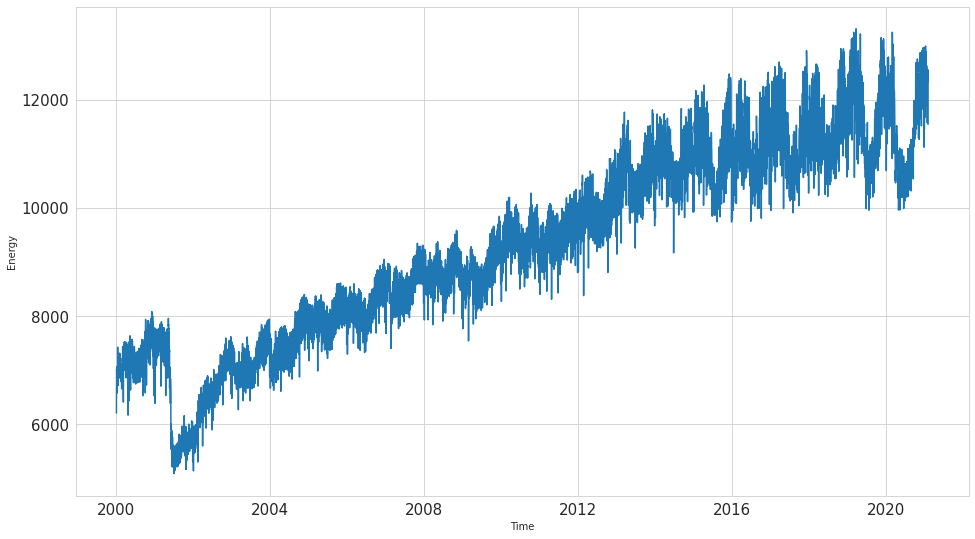

In [27]:
plt.rcParams["figure.figsize"] = [16,9]
plt.ylabel('Energy')
plt.xlabel('Time')
plt.plot(data['value'])

## 2.2 Test Data with one hundred first values

In [28]:
describe = data['value'].describe()
mode = data['value'].mode()
variant = data['value'].var()
print(f"Variant: {variant}")
print(f"Mode: {mode}")
for key in describe.keys():
    print(f"{key}: {describe[key]}")

Variant: 3292779.4518329976
Mode: 0    7160.0
1    7232.0
2    7319.0
3    7434.0
dtype: float64
count: 7701.0
mean: 9393.276347487339
std: 1814.601733668575
min: 5087.9
25%: 7976.7
50%: 9324.78
75%: 10914.15
max: 13306.963


## 2.3 Test Data with all values with another form

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


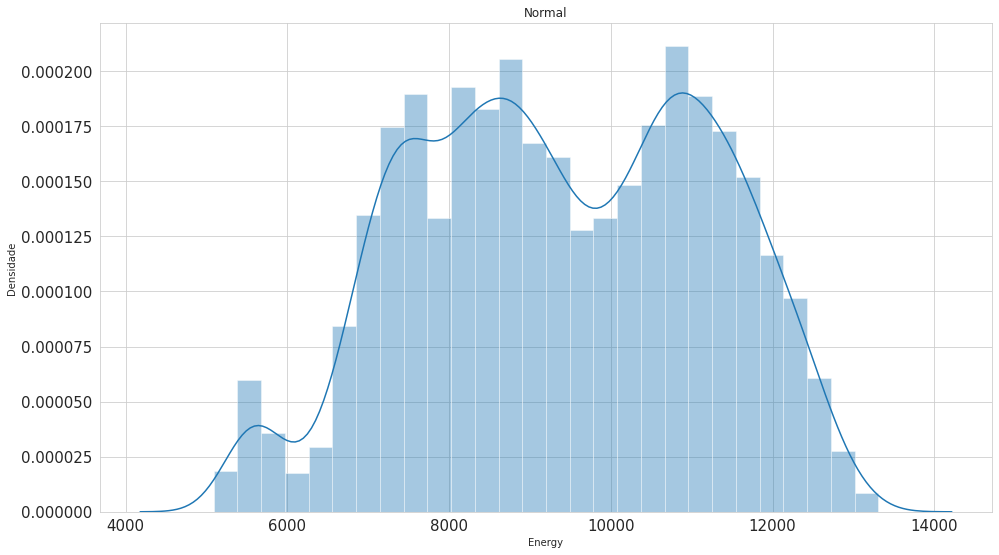

In [29]:
ax = sns.distplot(data['value'], kde=True)
ax.set(xlabel= 'Energy', ylabel='Densidade', title='Normal')
plt.show()

## 2.4 Line

Permite ver dados mes a mes.

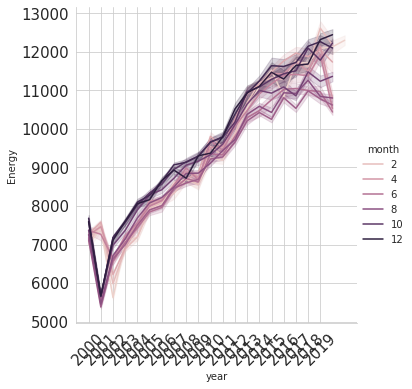

In [30]:
sns.relplot(data=data, x="year", y="value", hue="month", kind='line')
plt.ylabel('Energy')
plt.xticks(np.arange(2000, 2020, 1), rotation=45)
plt.show()
# data.hist(figsize=(15,12), column='value', by='month', bins=25)

## 2.5 Box-plot

Permiter ver as medianas e os quartis. Importante para ver como os dados estão distribuidos por ano.

Text(0, 0.5, 'Energy')

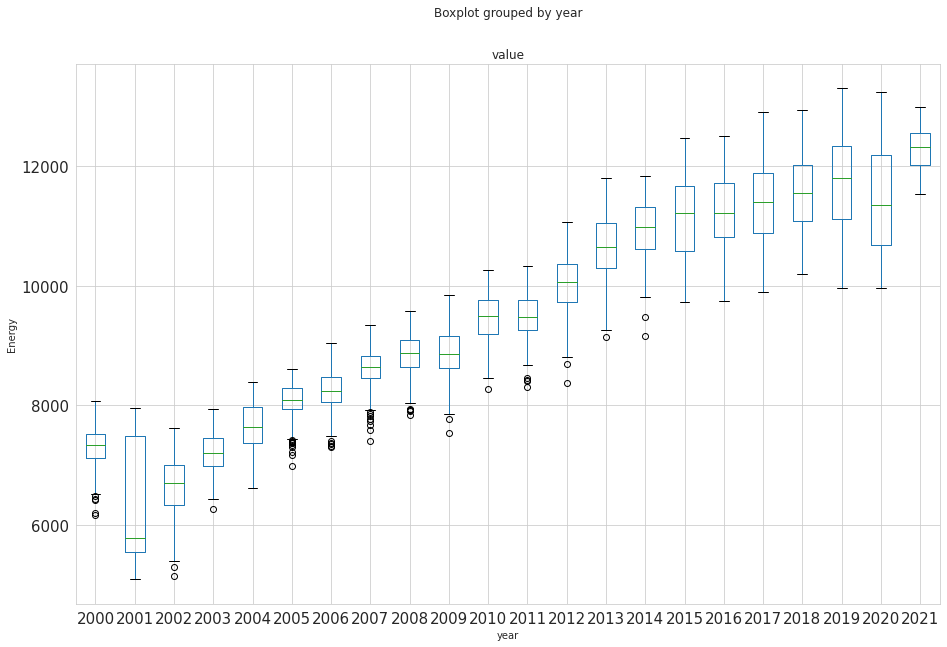

In [31]:
data.boxplot(figsize=(15,10), by='year', column=['value'])
plt.ylabel('Energy')

# 3. Transformation

## 3.1 Box-Cox transformation

A transformação de Box-Cox faz uma curva ficar normalmente distribuida, assim permitindo o usuario a fazer uma serie de testes que só podem ser usados em séries distribuidas assim.

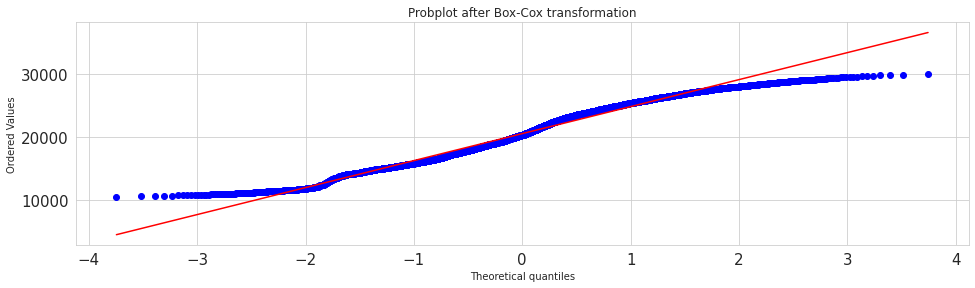

In [32]:
fig = plt.figure()
# ax1 = fig.add_subplot(211)
x = stats.loggamma.rvs(5, size=500) + 5
# prob = stats.probplot(data['value'], dist=stats.norm, plot=ax1)
# ax1.set_xlabel('')
# ax1.set_title('Probplot against normal distribution')
ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(data['value'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

## 3.2 Log transformation

A transformação Log diminui o vies dos dados.

None


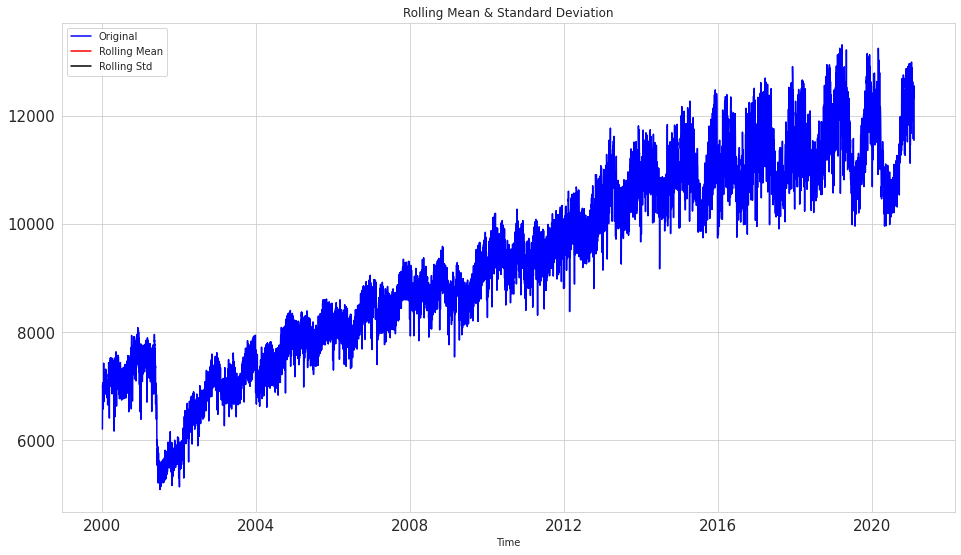

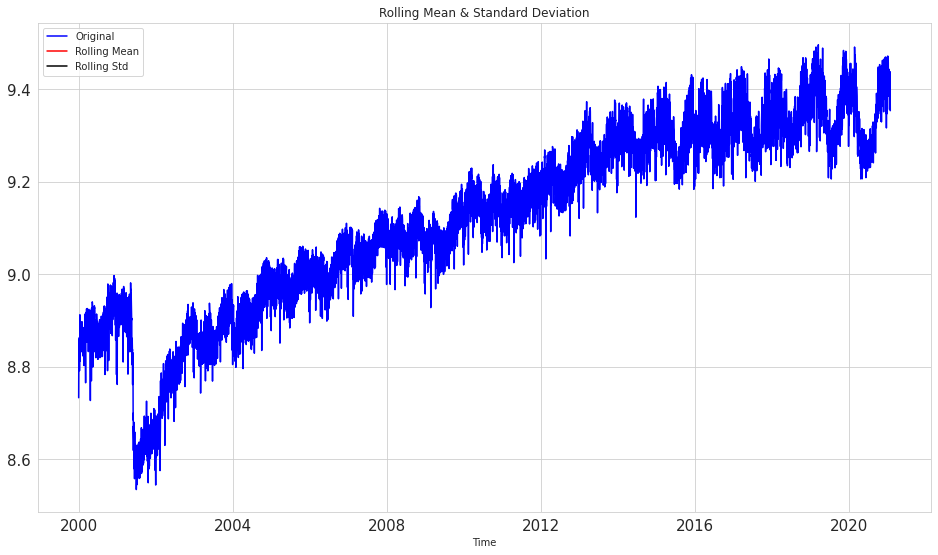

In [33]:
v_log = np.log(data['value'])
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
value = data['value']
print(pd.infer_freq(value.index))

def test_stationarity(timeseries, window_size=10000):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window_size).mean()
    rolstd  = timeseries.rolling(window_size).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Time')
    plt.show(block=False)

test_stationarity(data['value'])

test_stationarity(v_log)
# v_log.to_csv('data/exported/transformed_log.csv')

# 4. Decomposition

Divide serie temporal em tendencia, sazonalidade e aleatoriedade.

- Tendencia: Permite checar se serie temporal tem um padrão de aumento/diminuição dos valores com o tempo;
- Sazonalidade: Representa a variação recorrente(anual, mensal, semanal, ...);

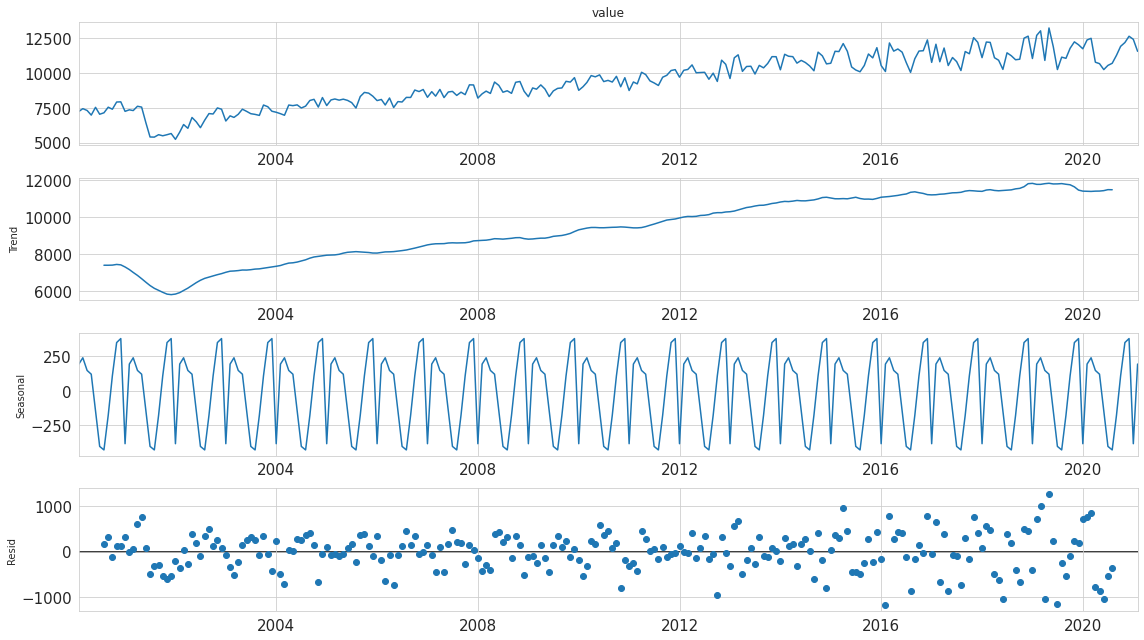

In [34]:
data.sort_index(inplace=True)
data.drop(['date', 'year', 'month', 'day', 'hour', 'weekday'],inplace=True,axis=1)

decomposition = sm.tsa.seasonal_decompose(data.value.asfreq('m'), model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

# 5. Tests

Finalidade: Determinar estacionariedade de uma série temporal.

## 5.1 Test KPPS

In [35]:
series = data['value']
statistic, p, lags, values = sm.tsa.kpss(series)
print(f"Test statistic: {statistic}")
print(f"P Value: {p}")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: 19.702133400567376
P Value: 0.01
Lags: 36
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## 5.2 Test PP

In [36]:
pp(series)

Test Statistic,-7.048
P-value,0.000
Lags,36


## 5.3 Test Fuller

In [37]:
statistic, p, lags, dont_know, values, test = sm.tsa.adfuller(series.head(10000))
print(f"Test statistic: {statistic}")
print(f"P Value: {p} ???")
print(f"Lags: {lags}")
for key in values.keys():
    print(f"{key}: {values[key]}")

Test statistic: -1.3110665899177107
P Value: 0.6240942496353318 ???
Lags: 35
1%: -3.4312034235233315
5%: -2.8619171497798384
10%: -2.5669707523119336


# 6. Persistence

O que o modelo de persistencia faz?

O modelo de persistencia fala que o valor de n é igual ao de n + 1.

In [38]:
split_date = '1/1/2019 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

test.head()

,value
index,
2019-01-01,10703.021
2019-01-02,11667.777
2019-01-03,12121.480
2019-01-04,12469.997
2019-01-05,11794.023


#### Concatenate train and test series to plotting

In [39]:
train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)
series

index
2000-01-01     6205.000
2000-01-02     6797.000
2000-01-03     7024.000
2000-01-04     6921.000
2000-01-05     7025.000
                ...    
2021-01-27    12308.892
2021-01-28    12550.095
2021-01-29    12413.574
2021-01-30    11988.032
2021-01-31    11540.266
Name: value, Length: 7702, dtype: float64

#### Prepare data

O resultado do modelo de persistencia da a baseline. Basicamente permite comparar outros modelos com o seu resultado para assim checar sua eficiencia.

Vantangens do modelo de persistencia:
- Simples
- Rapido
- Facil de replicar

In [40]:
def persistence(last_ob, n_steps):
    return [last_ob for i in range(n_steps)]


test = test.values
series = series.values
train = [x for x in train]

# Number of multi-step
n_steps = 3

# Store multi-step forecasts
forecasts = list()

# Number of multi-step forecasts
n_forecasts = len(test) - n_steps + 1

# Walk-forward validation
for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)

    # Store the multi-step forecast
    forecasts.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)

print(train[-10:])
print(forecasts[-10:])

[12258.734, 12175.406, 12367.506, 11874.637, 11568.613, 12271.288, 12550.309, 12308.892, 12550.095, 12413.574]
[[12365.629, 12365.629, 12365.629], [12258.734, 12258.734, 12258.734], [12175.406, 12175.406, 12175.406], [12367.506, 12367.506, 12367.506], [11874.637, 11874.637, 11874.637], [11568.613, 11568.613, 11568.613], [12271.288, 12271.288, 12271.288], [12550.309, 12550.309, 12550.309], [12308.892, 12308.892, 12308.892], [12550.095, 12550.095, 12550.095]]


#### Evaluate the forecasts

In [41]:
# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")


evaluate_forecasts(test, forecasts, n_steps)

t+1 RMSE: 450.5155665965485 | MAPE: 18.44416207025096
t+2 RMSE: 578.5856971618174 | MAPE: 21.1747976439719
t+3 RMSE: 625.6608854146413 | MAPE: 21.960477088336866


## 6.1 Plot the forecasts in multi steps

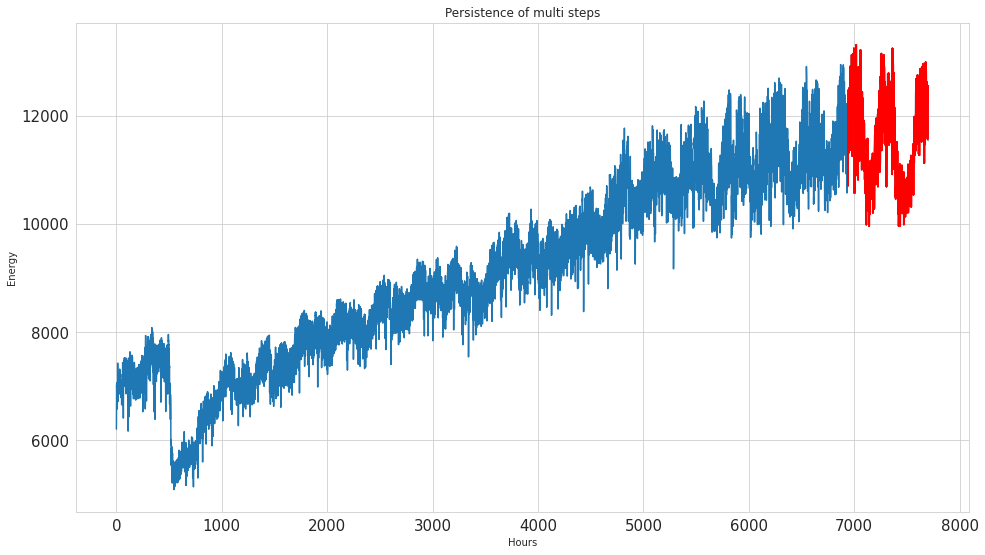

In [42]:
# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
    # Plot the entire dataset in blue
    x_points = []
    y_points = []

    # Plot the forecasts in red
    for i in range(len(forecasts)):
        # Start offset for x-axis
        off_s = len(series) - len(test) + i - 1

        # End offset for x-axis
        off_e = off_s + len(forecasts[i]) + 1

        # Indexes of x-axis for multi-step forecasts
        xaxis = [x for x in range(off_s, off_e)]
        x_points.append(xaxis)
        # xaxis = np.array(xaxis)

        # Values of muti-step fotecasts
        yaxis = [series[off_s]] + forecasts[i]
        y_points.append(yaxis)
        # yaxis = np.array(yaxis)

        # sns.lineplot(data=xaxis, color='blue')
        # sns.lineplot(data=yaxis, color='red')

    # Show the final plot
    plt.plot(series)
    plt.plot(x_points, y_points, color='red')
    plt.ylabel('Energy')
    plt.xlabel('Hours')
    plt.title('Persistence of multi steps')
    plt.show()


plot_forecasts(series, forecasts, test)

## 6.2 Persistence with one step

In [43]:
predictions = list()
for i in range(len(test)):
    # Predict
    yhat = train[-1]
    # Store forecast in list of predictions
    predictions.append(yhat)
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    # print(f">Predicted={yhat}, Expected={obs}")

#### Report performance

In [44]:
rmse = sqrt(mean_squared_error(test, predictions))
mape = sqrt(mean_absolute_error(test, predictions))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))

RMSE: 454.722 | MAPE:  19


#### Plot predicted vs expected values

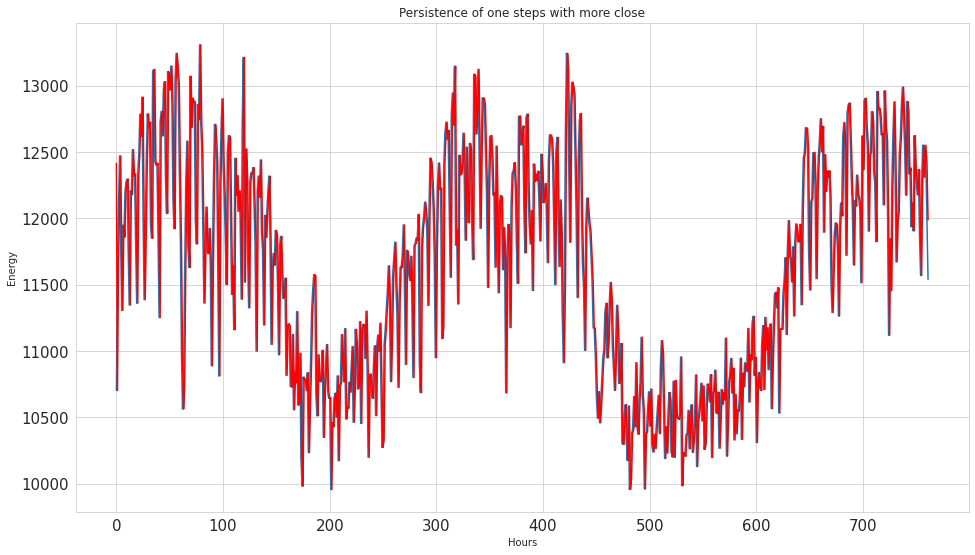

In [45]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.ylabel('Energy')
plt.xlabel('Hours')
plt.title('Persistence of one steps with more close')
plt.show()

# 7. Exponential smoothing


In [46]:
split_date = '01/01/2018 12:00:00 AM'
test = data[split_date : ]
train = data['01/01/2015 12:00:00 AM' : split_date]

train_v = train['value']
test_v = test['value']

test_vv = test_v.values
train_vv = [x for x in train_v]

pred = list()
pred_exp = list()

## 7.1 Simple Exponential Smoothing

[[11108.059111200459, 10986.673], [11035.227444480184, 11994.681], [11610.899577792075, 12263.865], [12002.678831116831, 12019.709], [12012.896932446733, 11923.778], [11959.425572978693, 11524.436], [11698.431829191477, 10819.809], [11171.25813167659, 11767.789], [11529.176652670638, 11830.09], [11709.724661068256, 11606.851], [11648.000464427303, 11683.605], [11669.36318577092, 12031.004], [11886.34767430837, 11251.355], [11505.352069723347, 10688.464], [11015.219227889338, 11930.58], [11564.435691155735, 11926.082], [11781.423476462294, 11717.82], [11743.261390584918, 11871.49], [11820.198556233967, 11798.03], [11806.897422493588, 11407.93], [11567.516968997435, 10682.88], [11036.734787598973, 12042.875], [11640.418915039589, 11959.457], [11831.841766015836, 11882.693], [11862.352506406334, 12368.003], [12165.742802562534, 12061.443], [12103.162921025014, 11341.625], [11646.240168410004, 10879.422], [11186.149267364002, 12197.014], [11792.6681069456, 12394.172], [12153.57044277824, 1

Text(0.5, 1.0, 'Holt Method with multi steps')

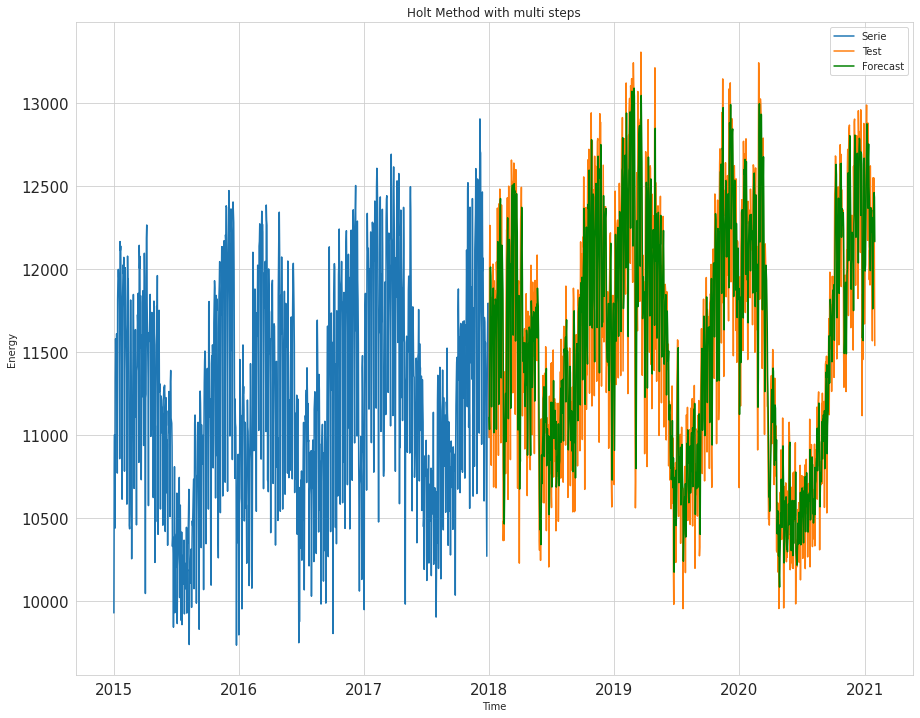

In [47]:
def simple_exp_smoothing(train, alpha, n_steps=1):
    estimated = SimpleExpSmoothing(train, initialization_method="estimated")
    _fit = estimated.fit(smoothing_level=alpha, optimized=False)
    return _fit.forecast(n_steps)

n_steps = 1
n_forecasts = len(test_vv) - n_steps + 1

for i in range(n_forecasts):
    forecast = simple_exp_smoothing(train_vv, 0.6, n_steps)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

print(pred_exp)

def evaluate_forecasts(test, forecasts, n_steps):
    for i in range(n_steps):
        # Picking the values from multi-step forecasts
        ypred_ts = [forecast[i] for forecast in forecasts]

        # Sliding window on test series
        ytrue_ts = test[i:len(ypred_ts)+i]
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        mape = sqrt(mean_absolute_error(ytrue_ts, ypred_ts))
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")


evaluate_forecasts(test_vv, pred, n_steps)

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index[n_steps-1:], pred, color='green')
plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.title('Holt Method with multi steps')

## 7.2 Holt's Winter

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retval

[[11170.70330603279, 10986.673], [11199.993574300954, 11994.681], [11351.2670711843, 12263.865], [11591.759645072023, 12019.709], [11690.66617439841, 11923.778], [11802.335285378507, 11524.436], [11671.152524621324, 10819.809], [11547.682423230384, 11767.789], [11637.135115906254, 11830.09], [11634.74640140681, 11606.851], [11635.970385316852, 11683.605], [11514.586850320637, 12031.004], [11623.044296815575, 11251.355], [11648.227438456533, 10688.464], [11424.191083841815, 11930.58], [11558.801768788013, 11926.082], [11636.830713493331, 11717.82], [11697.371642926213, 11871.49], [11646.71849696139, 11798.03], [11774.72304546482, 11407.93], [11737.646489250757, 10682.88], [11457.391108784997, 12042.875], [11594.490531130026, 11959.457], [11557.833665309097, 11882.693], [11595.882417316147, 12368.003], [11856.07742247428, 12061.443], [11935.192740011275, 11341.625], [11830.612047941151, 10879.422], [11615.247502790227, 12197.014], [11789.369029066527, 12394.172], [11836.244763808063, 122

Text(0.5, 1.0, 'Holt Winters')

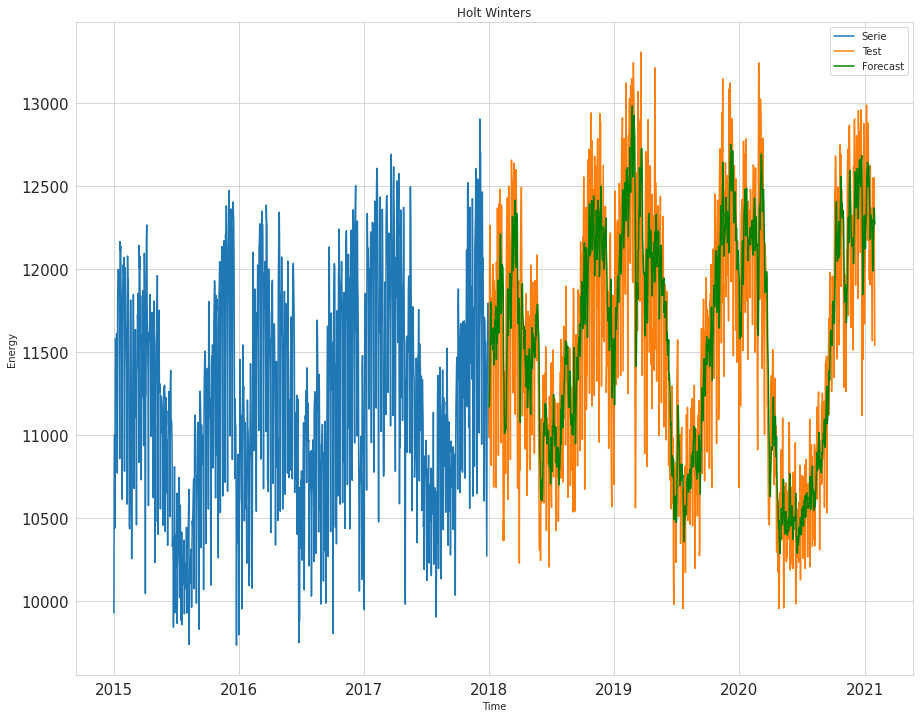

In [48]:
test_vv = test_v.values
train_vv = [x for x in train_v]

def holt_winter_method(train, n_steps=0):
    estimated = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add', use_boxcox=True, initialization_method="heuristic")
    _fit = estimated.fit(optimized=True)
    return _fit.forecast(n_steps)


pred = list()
pred_exp = list()
for i in range(len(test_vv)):
    # Predict
    forecast = holt_winter_method(train_vv)
    pred.append(forecast)

    obs = test_vv[i]
    train_vv.append(obs)
    pred_exp.append([forecast[0], obs])

print(pred_exp)
rmse = sqrt(mean_squared_error(test_vv, pred))
mape = sqrt(mean_absolute_error(test_vv, pred))
print('RMSE: %.3f | MAPE: %3.f' % (rmse, mape))

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, label='truth')
ax.plot(test.index, pred, color='green')

plt.legend(['Serie', 'Test', 'Forecast'])
plt.ylabel('Energy')
plt.xlabel('Time')
plt.title('Holt Winters')